# Time Series Forecasting with ARIMA

In [454]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

### Data

In [21]:
# examine shape of dataframe, variable types
print data.shape
print data.dtypes     

(2373, 4)
day.of.week         object
car.count            int64
weather            float64
cloud.indicator     object
dtype: object


In [569]:
data = pd.DataFrame.from_csv('/Users/lxu213/data/orbital-insights/data.csv', index_col=0) 
data.head()

,day.of.week,car.count,weather,cloud.indicator
date,,,,
2010-01-01,Friday,101,0.1,clear
2010-01-02,Saturday,34,0.2,cloudy
2010-01-03,Sunday,113,0.4,clear
2010-01-04,Monday,5,0.6,cloudy
2010-01-05,Tuesday,124,0.1,clear


In [23]:
# any missing values?
data.isnull().values.any()

False

### Exploratory Data Analysis

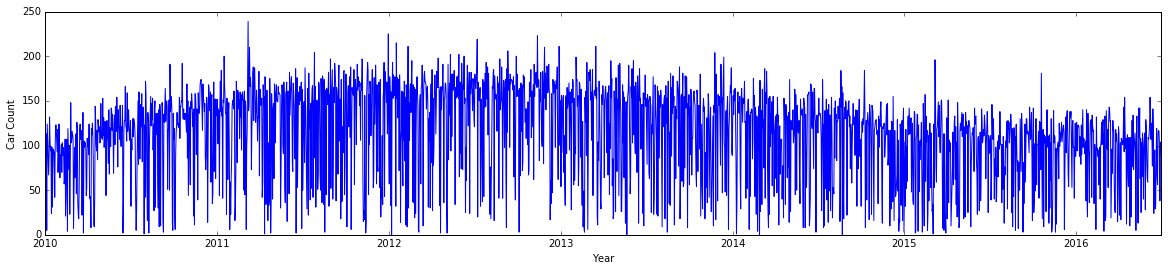

In [43]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Year')
ax.set_ylabel('Car Count')
plt.plot(data.index, data['car.count']);     

Initial thoughts on data: there's a strong trend throughout the data, with extreme fluctuations. Will need to look closer at the data using a shorter time frame to see why car count could as low as 0-5 on some days. I don't see any annual seasonal trends.

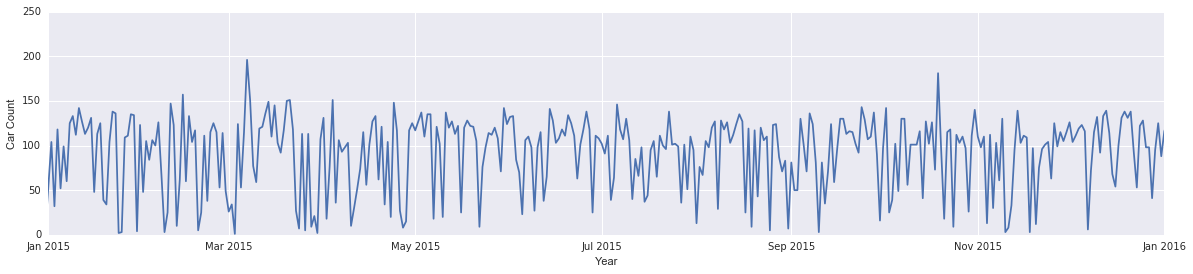

In [88]:
# car count for 2015
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2016,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Year')
ax.set_ylabel('Car Count')
plt.plot(data.index, data['car.count']);     


More initial thoughts: why is there so much variation? What are the sudden dips in data? Is it connected to weather and how cold/how much it rains? Probably not, people need to shop. Is it connected to how cloudy the aerial footage may be and the reliability of our data?

### Cloud Indicator Variable

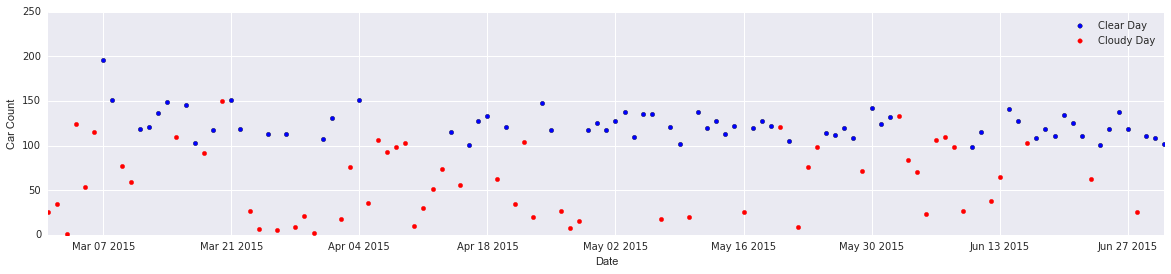

In [570]:
# let's take a closer look: summer 2015
start = datetime.datetime(2015,3,1)
end = datetime.datetime(2015,7,1)

cloudy_data = data.loc[(data['cloud.indicator'] == 'cloudy')]
clear_data = data.loc[(data['cloud.indicator'] == 'clear')]

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_ylim(0, 250)
ax.set_ylabel('Car Count')
plt.scatter(clear_data.index, clear_data['car.count'])  
plt.scatter(cloudy_data.index, cloudy_data['car.count'], color='r');     
ax.legend(['Clear Day', 'Cloudy Day'])


Using a scatterplot, I can see the individual daily car counts. All the days with very low car count are from cloudy days, when the aerial image is probably difficult to read. I would consider all the data from cloudy days as corrupt or to contain some degree of unreliability. 

### Outliers

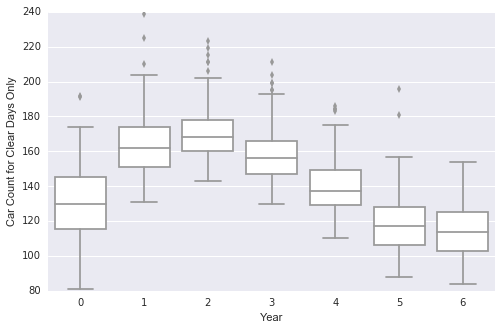

In [175]:
# plot outliers by year
data_boxplot = []
for year in range(2010, 2017):
    data_boxplot.append(clear_data.loc[(clear_data.index.year == year)]['car.count'])
    
import seaborn as sns
plt.figure(figsize=(8,5))
ax = plt.gca()
sns.boxplot(data=data_boxplot, color='w', whis=1.5)
ax.set_xlabel('Year')
ax.set_ylabel('Car Count for Clear Days Only');
# plt.boxplot(data_boxplot, whis=1.5, showfliers=True);   
# use seaborn over matplotlib since matplotlib is not showing outliers, annoyingly

Outlier analysis: if we keep all of the data (including from cloudy days), this will produce a misleading IQR, one much larger than the actual. For outlier analysis, let's remove all the data from cloudy days.

In [ ]:
# TODO remove outlier data from dataset

### Weather Variable

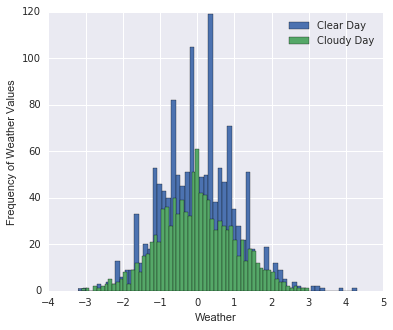

In [170]:
# frequency of Weather Indicator
plt.figure(figsize=(6,5))
ax = plt.gca()
ax.set_xlim(-4, 5)
plt.hist(clear_data['weather'], bins=60)
plt.hist(cloudy_data['weather'], bins=60)
ax.set_ylabel('Frequency of Weather Values')
ax.set_xlabel('Weather')
ax.legend(['Clear Day', 'Cloudy Day']);

Weather indicator doesn't appear to be well correlated with car count. 

Some ideas:
* Clear days are more likely to have a lower absolute value for weather. 
* Weather could be normalized temperature (easily verified by plotting over a year) 

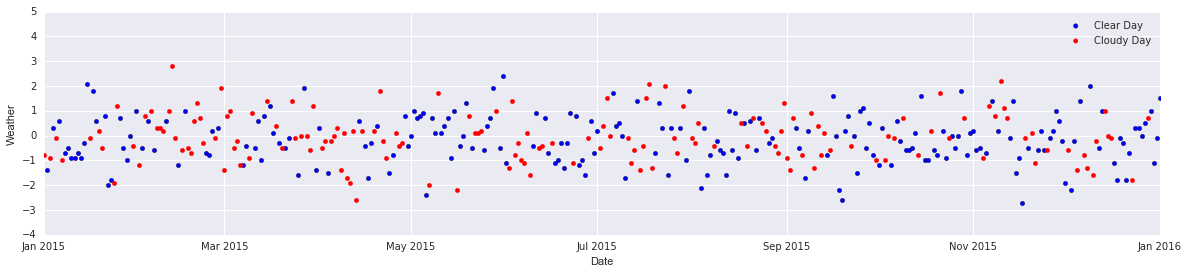

In [172]:
# seasonal trends for weather
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2016,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_ylabel('Weather')
plt.scatter(clear_data.index, clear_data['weather'])  
plt.scatter(cloudy_data.index, cloudy_data['weather'], color='r')     
ax.legend(['Clear Day', 'Cloudy Day']);



There is no obvious correlation between weather and temperature.




### Day of Week

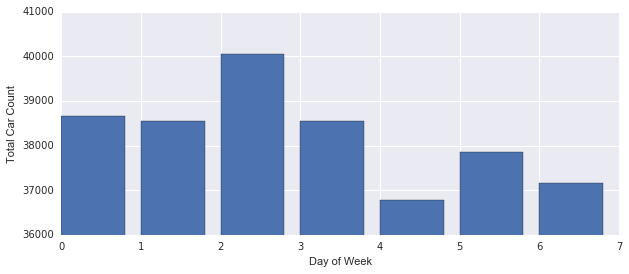

In [606]:
# TODO label properly x-axis
day = data['day.of.week'].unique()
plt.figure(figsize=(10,4))
ax = plt.gca()
plt.bar(np.arange(0,len(day)), data.groupby('day.of.week').sum()['car.count'])
ax.set_ylim(36000, 41000)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Car Count')

There is a day of week signal, could be an important feature to model on.

## Forecasting

Given this data is a timeseries with a decent amount of past values, let's use an ARIMA model for fitting and forecasting efforts. Unfortunately, I did not find the weather variable very useful and the cloud indicator simply helped throw out faulty data. The only other information is the time component, which will be used in the ARIMA model. 

To use ARIMA, I need to first ensure the data is stationary (time, variance, co-variance should not be dependent on time). I'll use the Dickey-Fuller Test Statitic (which statsmodel library includes already).

### Stationarity

In [607]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print df_results

In [608]:
test_stationarity(clear_data['car.count'])


Test Statistic            -1.544676
p-value                    0.511307
Lags                      20.000000
Observations            1332.000000
Critical Value (5%)       -2.863712
Critical Value (1%)       -3.435269
Critical Value (10%)      -2.567927
dtype: float64


Car count data is not stationary (test statistic is greater than critical value). Needs some transformations. 

In [609]:
# first difference
clear_data['diff'] = clear_data['car.count'] - clear_data['car.count'].shift(1)  
test_stationarity(clear_data['diff'].dropna(inplace=False))

#TODO: address warning 

Test Statistic         -1.090358e+01
p-value                 1.142956e-19
Lags                    2.400000e+01
Observations            1.327000e+03
Critical Value (5%)    -2.863720e+00
Critical Value (1%)    -3.435287e+00
Critical Value (10%)   -2.567931e+00
dtype: float64


/Users/lxu213/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


First difference has made the data stationary (test statistic sig. less than critical value so we can reject null ho).

### ACF and PACF Graphs

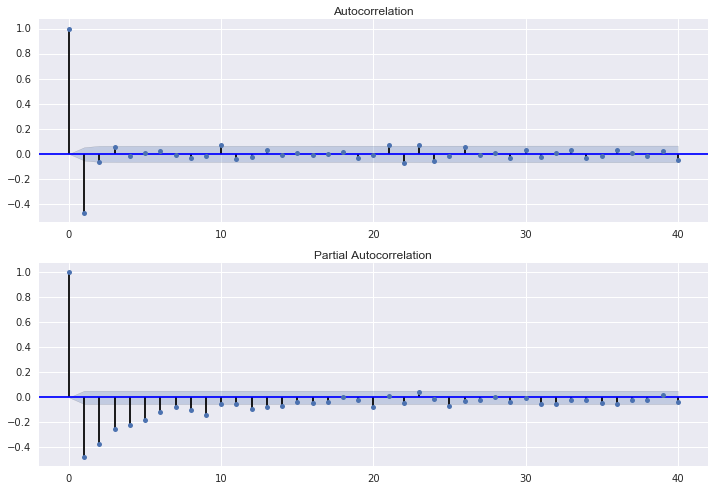

In [355]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(clear_data['diff'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(clear_data['diff'][1:], lags=40, ax=ax2)

It looks like the ACF is lagged by 1 and that PACF is geometric.



In [572]:
clear_data['car.count.float'] = clear_data['car.count'].astype(float)
# convert int to float for ARIMA model input
# TODO: do this in a cleaner way

/Users/lxu213/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [502]:
print type(clear_data['car.count.float'][5])

<type 'numpy.float64'>


### Fitting Model

                              ARMA Model Results                              
Dep. Variable:        car.count.float   No. Observations:                 1353
Model:                     ARMA(1, 0)   Log Likelihood               -5911.542
Method:                       css-mle   S.D. of innovations             19.107
Date:                Mon, 29 Jan 2018   AIC                          11829.084
Time:                        15:50:19   BIC                          11844.714
Sample:                    01-01-2010   HQIC                         11834.936
                         - 06-29-2016                                         
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                   143.6820      1.620     88.696      0.000       140.507   146.857
ar.L1.car.count.float     0.6798      0.020     34.036      0.000         0.641     0.719
        

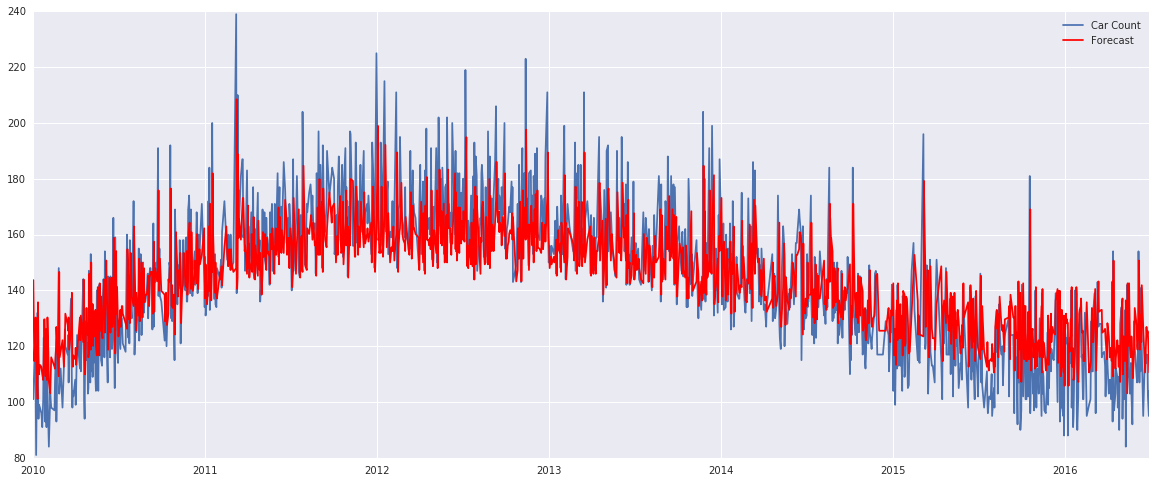

In [530]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['car.count.float'], order=(1,0,0)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['car.count'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])

print results.summary()

                              ARMA Model Results                              
Dep. Variable:        car.count.float   No. Observations:                 1353
Model:                     ARMA(1, 1)   Log Likelihood               -5602.656
Method:                       css-mle   S.D. of innovations             15.193
Date:                Mon, 29 Jan 2018   AIC                          11213.312
Time:                        21:20:33   BIC                          11234.152
Sample:                    01-01-2010   HQIC                         11221.115
                         - 06-29-2016                                         
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                   122.0706     20.633      5.916      0.000        81.631   162.510
ar.L1.car.count.float     0.9992      0.001   1309.303      0.000         0.998     1.001
ma.L1.ca

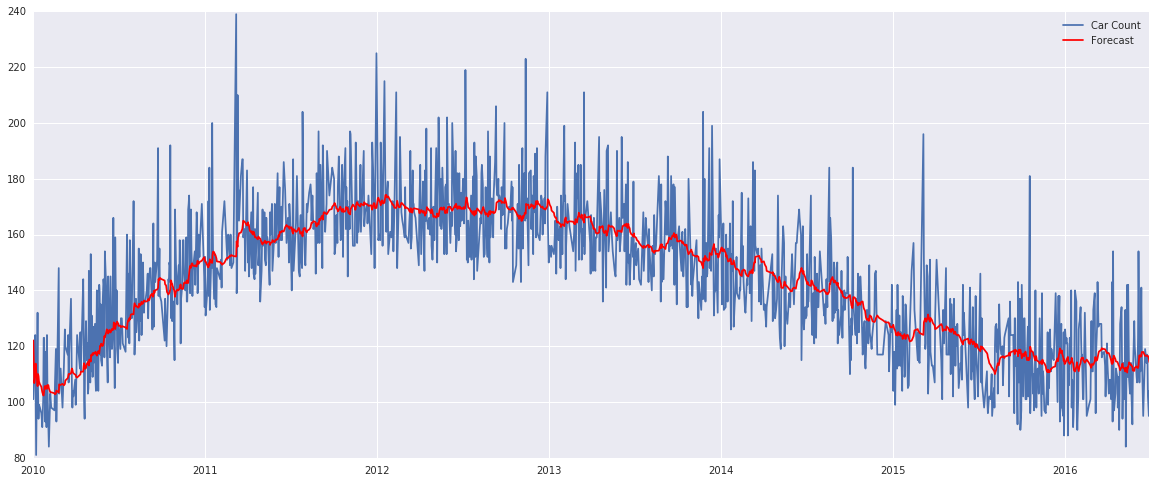

In [614]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['car.count.float'], order=(1,0,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['car.count'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])

print results.summary()

### Forecasting Model

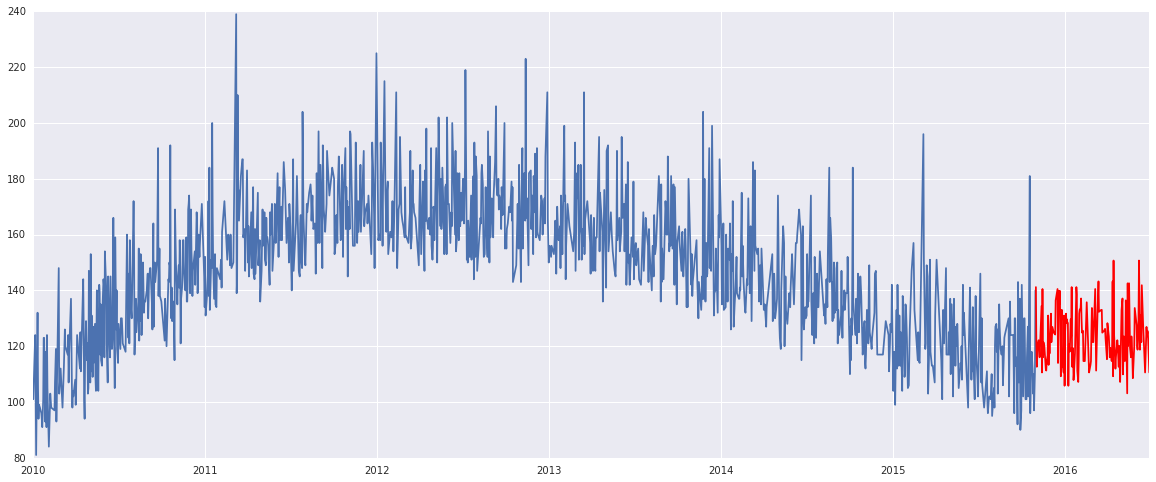

In [545]:
# forecast quick and dirty
# TODO: clean this up
fig = plt.figure(figsize=(20,8))
num_points = len(clear_data['car.count'])
x = results.predict(start=(1200), end=(1352), dynamic=False)

plt.plot(clear_data['car.count'][:1200])
plt.plot(x, color='r')

## Summary
The ARIMA(1,0,0) tends to capture the average of the overall trend, underpredicting during years of higher car count and overpredicting during years of lower car count. The trends from the earlier years cause the forecast prediction to be high. The ARIMA(1,0,1) does better with overall trend but does not do so great with the variability and noise.

Next steps if I had more time:
1. Trend from the past years (2015-2016) are more relevant than the trends from early years (2010-2012). I'd like to try and fit the ARIMA model to only the data from the past few years for forecasting the next year or two. 
2. I'd like to revisit the weather feature in case there is some correlation between it and car count
3. It would be interesting to see if the missing data from the cloudy days could be filled in with some extension techniques for stronger predictions.
4. There is a temporal signal on days of week that I would further investigate. It's possible with a few features like weather, day of week, and year, a more sophisticated algorithm could be trained to better predict car count.
5. I'd like to look closer at detecting the AR & MA (orders for ARIMA model) using ACF and PACF plots and evaluating the model fits - looking at likelihood function, sum of squares, etc.
6. Lastly, it would always be good to get more business context. For example, is there any indication that the downward trend from 2013 onward would continue? Has another Wal-mart been constructed 10 miles away in the year 2013 to compete with this one? Perhaps a shopping mall on the north side of town was constructed and the housing prices have started plummeting as home owners start moving to the north side of town? 